# PROJECT WORK
#### 1. Problem Description 

The dataset named Score is obtained from the website https://www.kaggle.com/nycopendata/high-schools. The dataset is a collection of 435 observations of the average score in SAT math, reading and writing tests from all high schools of 5 different boroughs in New York City. Below are the variables of the original dataset:

![ColumnName](./Fig/nyc/VariableNames.png)


For the scope of this project work, we focus on choosing only one variable and regress SAT average math scores based on that variable. The variable chosen here is the student enrollment. Comparing the original distribution of math scores vs. log-scale of math scores, log-scale math scores seems to follow normal distribution better. Therefore, we choose to build our models with log-scale math scores. 

Data distribution:
![Math](./Fig/nyc/Math.png)


#### 2. Model description

In the sections following, we will go through 4 different models:

- Pooled model: all borough belongs to the same distribution, log math scores is regressed based on the number of student enrollment.  Parameters are beta1, beta2 and sigma that are common for all boroughs.  
                                        y ~ N(beta1 + beta2*x, sigma) 
- Separate model: each borough has its own separate model. The parameters are alpha (unique for each borough), beta and sigma (common for all boroughs)
                                        mu = alpha_borough + beta*x
                                        y ~ N(mu, sigma)
- Varying slop and intercept model: each borough has its own separate model with both alpha and beta unique for each borough, sigma is common for all boroughs. Alpha and beta follows normal distribution with priors:
                                        mu_alpha ~ N(0,1)
                                        mu_beta ~ N(0,1)
                                        alpha ~ N(mu_alpha, sigma_alpha)
                                        alpha ~ N(mu_alpha, sigma_alpha)
                                        mu = alpha_borough + beta_borough*x
                                        y ~ N(mu, sigma)
- Hierarchical model with no regressor: each borough has its own parameters mu that follows a normal distribution (mu0, sigma0) and shared sigma.
                                  mu ~ (mu0, sigma0)
                                  y ~ (mu, sigma)
                                        
For evaluation purpose, we split up training-test data to evaluate the accuracy of each models. 

The codes are passed to PyStan and simulated with 2 chains in 1000 iterations. 

#### 2.1. Pooled model 

Stan code:

`data {
    int<lower=0>  N;
    int<lower=0> M;
    vector[N] x;
    vector[M] x_test;
    vector[N] y;
}
parameters {
    vector[2] beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(beta[1] + beta[2]*x, sigma);
}
generated quantities{
    vector[N] log_lik;
    vector[M] y_pred_test;
    for (i in 1:M)
     y_pred_test[i] = normal_rng(beta[1] + beta[2]*x_test[i], sigma);
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| beta[1] + beta[2]*x[i], sigma);
}`

#### 2.2. Separate model 

Stan code

`data{
    int<lower=0> N;
    int<lower=1, upper=5> boroughs[N]; #borough indicator
    vector[N] x;
    vector[N] y;
}
parameters {
    vector[4] alpha;
    real beta; #only 1 beta, not a vector
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;  
    for (i in 1:N)
        mu[i] <- beta* x[i] + alpha[boroughs[i]];
}
model {
    y ~ normal(mu, sigma);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| mu[i], sigma);
}`

#### 2.3. Varying intercept and slope model 
Stan code:

`data {
  int<lower=0> N;
  int<lower=0> J;
  vector[N] y;
  vector[N] x;
  int boroughs[N];
}
parameters {
  real<lower=0> sigma;
  real<lower=0> sigma_a;
  real<lower=0> sigma_b;
  vector[J] alpha;
  vector[J] beta;
  real mu_a;
  real mu_b;
}
transformed parameters {
    vector[N] mu;  
    for (i in 1:N)
        mu[i] <- alpha[boroughs[i]] + beta[boroughs[i]]*x[i];
}
model {
  mu_a ~ normal(0, 1);
  mu_b ~ normal(0, 1);
  alpha ~ normal(mu_a, sigma_a);
  beta ~ normal(mu_b, sigma_b);
  y ~ normal(mu, sigma);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| mu[i], sigma);
}`

#### 2.4. Hierarchical model 
Stan code:

`data {
    int<lower=1> N;
    int<lower=1> K;
    matrix[N, K] y;
}
parameters {
    real mu0;
    real<lower=0> sigma0;
    vector[K] mu;
    real<lower=0> sigma;
}
model {
    for (j in 1:K){
        mu[j] ~ normal(mu0, sigma0);
        y[:,j] ~ normal(mu[j], sigma);
     }
}
generated quantities {
    real mupred;
    mupred <- normal_rng(mu0, sigma0);
}`

#### 3. Convergence and Result
#### 3.1. Pooled model 

R-hat for all variables is approximately 1.0, so we can conclude that the model has converged. Checking effective sample size and divergence returns value True, meaning that there is no problem with the model. The graph below demonstrates the fitted line. 
![Pooledmodel](./Fig/nyc/PooledModel.png)


#### 3.2. Separate model  
R-hat for all variables is approximately 1.0, so we can conclude that the model has converged. Checking effective sample size and divergence returns value True, meaning that there is no problem with the model.
Alpha (intercept) calculated for different boroughs:
![Sepmodel_alpha](./Fig/nyc/Intercept_separate.png)

#### 3.3. Varying intercept and slope model
R-hat for all variables is above 1.1 or below 0.9, so we can conclude that the model has not converged. The model will not be selected for evaluation. 

#### 3.4. Hierarchical model  
R-hat for all variables is above 1.1 or below 0.9, so we can conclude that the model has not converged. The model will not be selected for evaluation.

#### 4. Model evaluation with Psis-loo 

Two methods for model evaluation has been used in this project: psis-loo and MAE.

Psisloo results for each model:

| Measurements | Pooled model | Separate model | 
| --- | --- | --- |
| psis-loo | 114.74 | 125.60 | 
| p_eff | 3.79 | 7.38 |
| k > 0.5 | None | Some | 

Scatter plot of ks values for different models:

- Pooled model: all k values is below 0.5. We can conclude that the parameter estimations of the model is reliable.

![k_values_pooled](./Fig/nyc/k_pooled.png)

- Separate model: all k values is below 0.5. We can conclude that the parameter estimations of the model is reliable.

![k_values_separate](./Fig/nyc/k_separate.png)


#### 5. Posterior predictive checking  
MAE and MSE results for each model:

| Measurements | Pooled model | Separate model | 
| --- | --- | --- | 
| MAE | 0.095 | 0.085 | 
| MSE| 0.014 | 0.013 | 

Posterior distribution:

- Pooled model
- Separate model
 

Model comparison: Pooled model is most suitable for the dataset, as it has lowest score in both MAE and MSE. Hierarchical model and Varying Intercept and Slope model do not converge.

#### 6. Conclusion and potential improvements
In conclusion, it seems that pooled model performs the best. 

<What can be concluded from the result? Does school level affect performance? Does teaching experience affect performance? What to do to maximize math score result?>

Within the scope of this project, we only explore one variable effect on math score results. Further analysis can be done with additional variables to improve prediction accuracy.  

#### 7. References

Codes adapted from Fonnesbeck, C. A Primer on Bayesian Multilevel Modeling using PyStan. URL: http://mc-stan.org/users/documentation/case-studies/radon.html?fbclid=IwAR3h_03XtQnyJQ18EOdREkPX-4biDX7c5AN5e9DPQzQLZ6hB2JRFh1gHemQ

Dataset collected from Rdatasets. URL: https://www.kaggle.com/nycopendata/high-schools

In [41]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import stanity
import pystan
import pystan.diagnostics



In [42]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [43]:
np.random.seed(100)

In [44]:
score = pd.read_csv('scores.csv', index_col=0, header = 0)
score.head()

,School Name,Borough,Building Code,Street Address,City,State,Zip Code,Latitude,Longitude,Phone Number,...,End Time,Student Enrollment,Percent White,Percent Black,Percent Hispanic,Percent Asian,Average Score (SAT Math),Average Score (SAT Reading),Average Score (SAT Writing),Percent Tested
School ID,,,,,,,,,,,,,,,,,,,,,
02M260,Clinton School Writers and Artists,Manhattan,M933,425 West 33rd Street,Manhattan,NY,10001,40.75321,-73.99786,212-695-9114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06M211,Inwood Early College for Health and Informatio...,Manhattan,M052,650 Academy Street,Manhattan,NY,10002,40.86605,-73.92486,718-935-3660,...,3:00 PM,87.0,3.4%,21.8%,67.8%,4.6%,NaN,NaN,NaN,NaN
01M539,"New Explorations into Science, Technology and ...",Manhattan,M022,111 Columbia Street,Manhattan,NY,10002,40.71873,-73.97943,212-677-5190,...,4:00 PM,1735.0,28.6%,13.3%,18.0%,38.5%,657.0,601.0,601.0,91.0%
02M294,Essex Street Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,212-475-4773,...,2:45 PM,358.0,11.7%,38.5%,41.3%,5.9%,395.0,411.0,387.0,78.9%
02M308,Lower Manhattan Arts Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,212-505-0143,...,3:00 PM,383.0,3.1%,28.2%,56.9%,8.6%,418.0,428.0,415.0,65.1%


In [45]:
score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 435 entries, 02M260 to 27Q323
Data columns (total 21 columns):
School Name                    435 non-null object
Borough                        435 non-null object
Building Code                  435 non-null object
Street Address                 435 non-null object
City                           435 non-null object
State                          435 non-null object
Zip Code                       435 non-null int64
Latitude                       435 non-null float64
Longitude                      435 non-null float64
Phone Number                   435 non-null object
Start Time                     431 non-null object
End Time                       431 non-null object
Student Enrollment             428 non-null float64
Percent White                  428 non-null object
Percent Black                  428 non-null object
Percent Hispanic               428 non-null object
Percent Asian                  428 non-null object
Average Score (SAT Math

In [46]:
df = score.loc[:,['School Name', 'Borough', 'Student Enrollment', 'Average Score (SAT Math)']]
df.columns = ['SchoolName', "Borough", "Enrollment", "math"]
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 435 entries, 02M260 to 27Q323
Data columns (total 4 columns):
SchoolName    435 non-null object
Borough       435 non-null object
Enrollment    428 non-null float64
math          375 non-null float64
dtypes: float64(2), object(2)
memory usage: 17.0+ KB


In [47]:
df.dropna(inplace=True)
print(df.Borough.value_counts())

Brooklyn         109
Bronx             98
Manhattan         89
Queens            69
Staten Island     10
Name: Borough, dtype: int64


In [48]:
st_island = df.index[df.Borough == 'Staten Island']

In [49]:
df.shape

(375, 4)

In [50]:
test_df = df.loc[st_island, :]

In [51]:
df.drop(st_island, inplace=True)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 01M539 to 27Q323
Data columns (total 4 columns):
SchoolName    365 non-null object
Borough       365 non-null object
Enrollment    365 non-null float64
math          365 non-null float64
dtypes: float64(2), object(2)
memory usage: 14.3+ KB


In [53]:
df.Borough.unique()

array(['Manhattan', 'Bronx', 'Queens', 'Brooklyn'], dtype=object)

In [54]:
replace_map = {'Borough':{'Manhattan': 1, 'Bronx': 2, 'Queens':3, 'Brooklyn':4}}
df.replace(replace_map, inplace = True)
print(df.head())
boroughs = df.Borough.unique()
print(boroughs)

                                                  SchoolName  Borough  \
School ID                                                               
01M539     New Explorations into Science, Technology and ...        1   
02M294                                  Essex Street Academy        1   
02M308                          Lower Manhattan Arts Academy        1   
02M545       High School for Dual Language and Asian Studies        1   
01M292         Henry Street School for International Studies        1   

           Enrollment   math  
School ID                     
01M539         1735.0  657.0  
02M294          358.0  395.0  
02M308          383.0  418.0  
02M545          416.0  613.0  
01M292          255.0  410.0  
[1 2 3 4]


In [55]:
df.corr()['math'].sort_values()

Borough      -0.111108
Enrollment    0.452911
math          1.000000
Name: math, dtype: float64

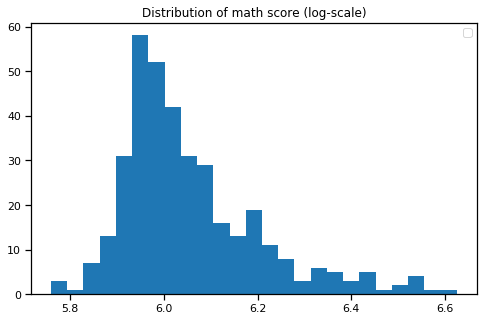

In [56]:
plt.figure(figsize = (8,5))
plt.hist(np.log(df.math), bins = 25)
plt.title("Distribution of math score (log-scale)")
plt.legend()
plt.show()

### Train/Test Split

In [57]:
X = df.drop('math', axis=1)
Y = np.log(df.math)

In [58]:
indices = range(df.shape[0])
i_boroughs= []
len_iboroughs = []

In [59]:
for s in boroughs:
    i_borough = np.where(df.Borough == s)[0]
    len_iboroughs.append(len(i_borough))
    i_boroughs.append(i_borough)

In [60]:
min_len = min(len_iboroughs)
train_size = round(min_len*0.8)

In [61]:
train_idx = []
test_idx = []

In [62]:
for s in i_boroughs:
    np.random.shuffle(s)
    train_idx = np.concatenate((train_idx, s[:train_size]), axis=None)
    test_idx = np.concatenate((test_idx, s[train_size:]), axis=None)

In [63]:
df.shape[0]

365

In [64]:
len(train_idx)

220

In [65]:
len(test_idx)

145

In [66]:
X_train = X.iloc[train_idx,:]
X_test = X.iloc[test_idx,:].reset_index()
Y_train = Y.iloc[train_idx]
Y_test = Y.iloc[test_idx]

(array([ 2.,  4., 15., 38., 28., 18., 12.,  7.,  6.,  4.,  4.,  3.,  2.,
         0.,  2.]),
 array([5.7651911 , 5.81890389, 5.87261668, 5.92632947, 5.98004227,
        6.03375506, 6.08746785, 6.14118064, 6.19489343, 6.24860622,
        6.30231901, 6.3560318 , 6.40974459, 6.46345738, 6.51717017,
        6.57088296]),
 <a list of 15 Patch objects>)

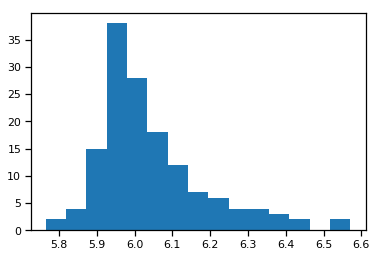

In [67]:
plt.hist(Y_test, bins = 15)

## Pooled model 

In [68]:
pooled_code = """
data {
    int<lower=0>  N;
    int<lower=0> M;
    vector[N] x;
    vector[M] x_test;
    vector[N] y;
}
parameters {
    vector[2] beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(beta[1] + beta[2]*x, sigma);
}
generated quantities{
    vector[N] log_lik;
    vector[M] y_pred_test;
    for (i in 1:M)
     y_pred_test[i] = normal_rng(beta[1] + beta[2]*x_test[i], sigma);
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| beta[1] + beta[2]*x[i], sigma);
}

"""

In [69]:

pool_data = {
    'N': Y_train.shape[0], 
    'M': Y_test.shape[0],
    'x': X_train.loc[:,'Enrollment'],
    'x_test': X_test.loc[:,'Enrollment'],
    'y': Y_train,
}

In [70]:
pooled_fit = pystan.stan(model_code=pooled_code, data = pool_data, iter = 1000, chains = 2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_174aac4ec68a4e0adc2676445f7b9556 NOW.
/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp237wt2hs/stanfit4anon_model_174aac4ec68a4e0adc2676445f7b9556_8582388925517822565.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [71]:
print("Rhat check : ",pystan.diagnostics.check_rhat(pooled_fit))
print("N_eff check : ",pystan.diagnostics.check_n_eff(pooled_fit))
print("Divergence check: ", pystan.diagnostics.check_div(pooled_fit))

Rhat check :  True
N_eff check :  True
Divergence check:  True


psisloo:  114.27120365734639
p_eff:  4.396478635483916


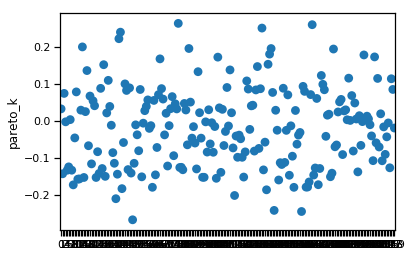

In [72]:
pooled_sample = pooled_fit.extract(permuted=True)

loglik = (pooled_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("psisloo: ",psisloo.elpd)
psisloo.plot()
lppd_pooled = 0 
for i in range (Y_train.shape[0]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print("p_eff: ", peff_pooled)


In [73]:
psisloo.print_summary()

greater than 0.5    0.0
greater than 1      0.0
dtype: float64

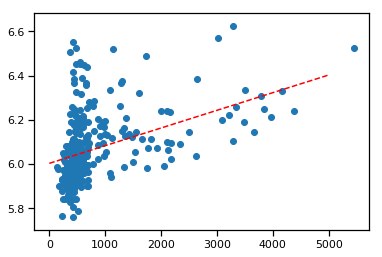

In [74]:
b0, m0 = pooled_sample['beta'].T.mean(1)
plt.scatter(df.Enrollment, np.log(df.math))
xvals = np.linspace(0,5000)
plt.plot(xvals, m0*xvals+b0, 'r--')
plt.show()


0.094

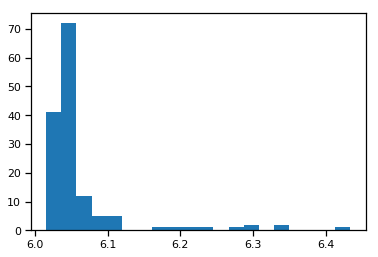

In [75]:
#Comparing y_pred with y_test
y_pred = np.mean(pooled_sample["y_pred_test"], axis=0)
plt.hist(y_pred, bins = 20)
round(MAE(Y_test, y_pred),3)

In [76]:
round(MSE(Y_test, y_pred),3)

0.014

##  Separate model

In [77]:
separate_code = """
data{
    int<lower=0> N;
    int<lower=1, upper=5> boroughs[N]; #borough indicator
    vector[N] x;
    vector[N] y;
}
parameters {
    vector[4] alpha;
    real beta; #only 1 beta, not a vector
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;  
    for (i in 1:N)
        mu[i] <- beta* x[i] + alpha[boroughs[i]];
}
model {
    y ~ normal(mu, sigma);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| mu[i], sigma);
}
"""

In [78]:
separate_data = {'N': X_train.shape[0],
                 'boroughs': X_train.Borough,
                 'x': X_train.loc[:,'Enrollment'],
                 'y': Y_train }

In [79]:
separate_fit = pystan.stan(model_code = separate_code, data = separate_data, iter = 1000, chains = 2)
separate_sample = separate_fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aae52bba719395c276d180e52079c523 NOW.
/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpua__yk6i/stanfit4anon_model_aae52bba719395c276d180e52079c523_573625073612541637.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [80]:
print("Rhat check : ",pystan.diagnostics.check_rhat(separate_fit))
print("N_eff check : ",pystan.diagnostics.check_n_eff(separate_fit))
print("Divergence check: ", pystan.diagnostics.check_div(separate_fit))

Rhat check :  True
N_eff check :  True
Divergence check:  True


In [81]:
alpha = np.mean(separate_fit['alpha'], axis=0)
beta = np.mean(separate_fit['beta'])

psisloo:  125.87970321486277
p_eff:  7.234032612050086


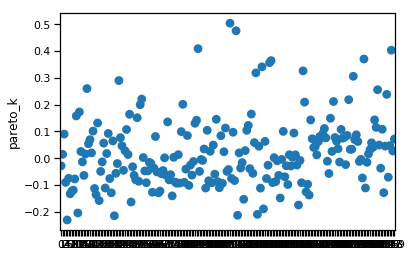

In [82]:
loglik = (separate_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("psisloo: ",psisloo.elpd)
psisloo.plot()
lppd_pooled = 0 
for i in range (Y_train.shape[0]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print("p_eff: ", peff_pooled)

In [83]:
psisloo.print_summary()

greater than 0.5    0.004545
greater than 1      0.000000
dtype: float64

(array([41., 72., 12.,  5.,  5.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,
         2.,  0.,  2.,  0.,  0.,  0.,  1.]),
 array([6.01494291, 6.03588852, 6.05683413, 6.07777975, 6.09872536,
        6.11967097, 6.14061658, 6.16156219, 6.1825078 , 6.20345342,
        6.22439903, 6.24534464, 6.26629025, 6.28723586, 6.30818147,
        6.32912708, 6.3500727 , 6.37101831, 6.39196392, 6.41290953,
        6.43385514]),
 <a list of 20 Patch objects>)

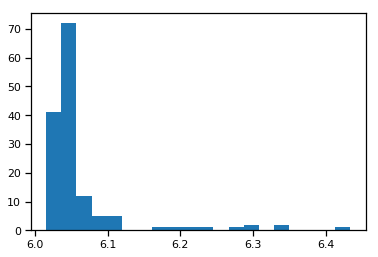

In [85]:
Y_pred = []
for i in range(X_test.shape[0]):
    borough = X_test.loc[i, 'Borough']
    Y_pred.append(alpha[borough-1] + beta*X_test.loc[i, 'Enrollment'])

plt.hist(y_pred, bins = 20)

In [86]:
MAE(Y_pred, Y_test)

0.0865400999356269

In [87]:
MSE(Y_pred, Y_test)

0.01333292442605992

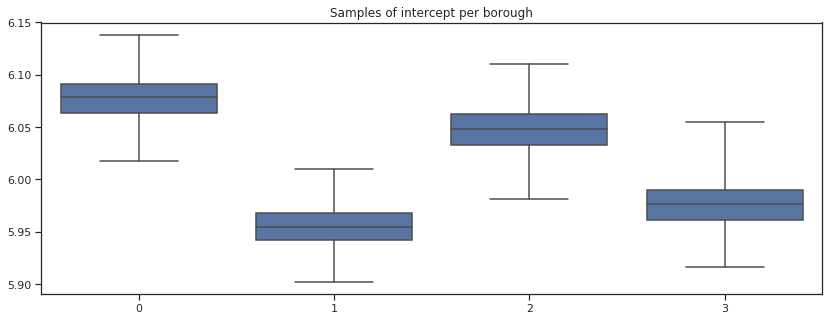

In [88]:
import seaborn as sns
sns.set(style="ticks")

a_sample = pd.DataFrame(separate_fit['alpha'])
plt.figure(figsize=(14, 5))
sns.boxplot(data=a_sample, whis=np.inf, color="b")
plt.title("Samples of intercept per borough")
plt.show()


# Varying intercept and slope model

In [89]:
varying_intercept_slope = """
data {
  int<lower=0> N;
  int<lower=0> J;
  vector[N] y;
  vector[N] x;
  int boroughs[N];
}
parameters {
  real<lower=0> sigma;
  real<lower=0> sigma_a;
  real<lower=0> sigma_b;
  vector[J] alpha;
  vector[J] beta;
  real mu_a;
  real mu_b;
}
transformed parameters {
    vector[N] mu;  
    for (i in 1:N)
        mu[i] <- alpha[boroughs[i]] + beta[boroughs[i]]*x[i];
}
model {
  mu_a ~ normal(0, 1);
  mu_b ~ normal(0, 1);

  alpha ~ normal(mu_a, sigma_a);
  beta ~ normal(mu_b, sigma_b);
  y ~ normal(mu, sigma);
}

generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| mu[i], sigma);
}

"""

In [90]:
varying_intercept_slope_data = {'N': X_train.shape[0],
                          'J': 4,
                          'boroughs': X_train.Borough,
                          'x': X_train.loc[:,'Enrollment'],
                          'y': Y_train}

varying_intercept_slope_fit = pystan.stan(model_code=varying_intercept_slope, 
                                          data=varying_intercept_slope_data, 
                                          iter=1000, chains=2)
varying_intercept_slope_sample = varying_intercept_slope_fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_989c483a074c9067ebf9bb4c197bcf99 NOW.
/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpnnmxntyl/stanfit4anon_model_989c483a074c9067ebf9bb4c197bcf99_3942053905460856220.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [91]:
print("Rhat check : ",pystan.diagnostics.check_rhat(varying_intercept_slope_fit))
print("N_eff check : ",pystan.diagnostics.check_n_eff(varying_intercept_slope_fit))
print("Divergence check: ", pystan.diagnostics.check_div(varying_intercept_slope_fit))

Rhat check :  False


N_eff check :  True
Divergence check:  False


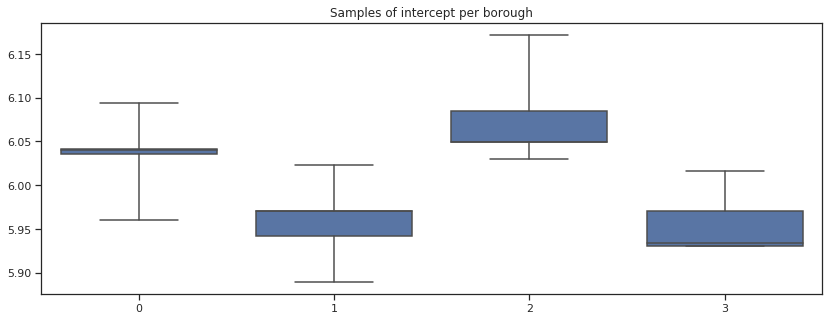

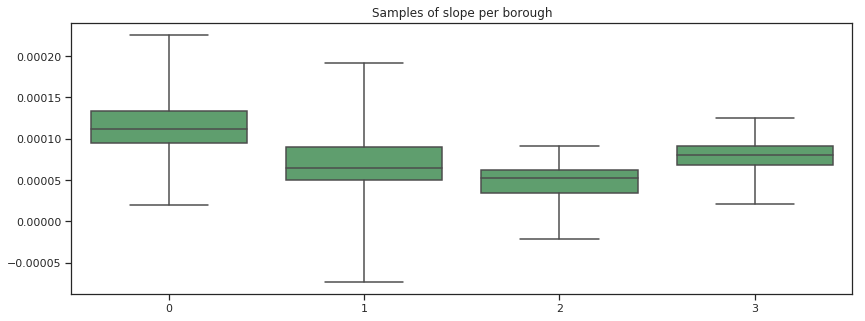

In [92]:
sns.set(style="ticks")

a_sample = pd.DataFrame(varying_intercept_slope_sample['alpha'])
plt.figure(figsize=(14, 5))
sns.boxplot(data=a_sample, whis=np.inf, color="b")
plt.title("Samples of intercept per borough")
plt.show()

b_sample = pd.DataFrame(varying_intercept_slope_sample['beta'])
plt.figure(figsize=(14, 5))
sns.boxplot(data=b_sample, whis=np.inf, color = 'g')
plt.title("Samples of slope per borough")
plt.show()


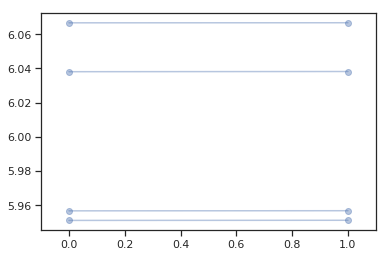

In [93]:
xvals = np.arange(2)
b = varying_intercept_slope_fit['alpha'].mean(axis=0)
m = varying_intercept_slope_fit['beta'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);

psisloo:  128.84553073286884
p_eff:  6.931903938751532


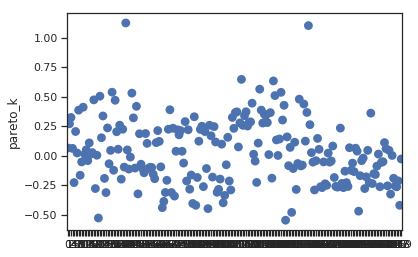

In [94]:
loglik = (varying_intercept_slope_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("psisloo: ",psisloo.elpd)
psisloo.plot()
lppd_pooled = 0 
for i in range (Y_train.shape[0]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print("p_eff: ", peff_pooled)

In [95]:
psisloo.print_summary()

greater than 0.5    0.045455
greater than 1      0.009091
dtype: float64

In [ ]:
#Predict y_pred, not in use because model not diverge
"""y_pred = []
for i in range(len(Y_test)):
    boroughindx = X_test.Borough[i] 
    y_pred.append(b[boroughindx] + m[boroughindx]*X_test.Enrollment[i])
print(round(MAE(Y_test, y_pred),3))
round(MSE(Y_test, y_pred),3)
plt.hist(y_pred, bins = 20)
"""

## Hierarchical model

In [ ]:
hierarchical_code = """
data {
    int<lower=1> N;
    int<lower=1> K;
    matrix[N, K] y;
}
parameters {
    real mu0;
    real<lower=0> sigma0;
    vector[K] mu;
    real<lower=0> sigma;
}
model {
    for (j in 1:K){
        mu[j] ~ normal(mu0, sigma0);
        y[:,j] ~ normal(mu[j], sigma);
     }
}
generated quantities {
    real mupred;
    mupred <- normal_rng(mu0, sigma0);
}
"""

In [ ]:
data = []
for s in i_boroughs:
    np.random.shuffle(s)
    s = s[:min_len]
    data.append(Y.iloc[s])

In [ ]:
data = np.array(data)

In [ ]:
y_test = np.log(test_df.math)

data_hierarchical = {
    'N': data.shape[0],
    'K': data.shape[1],
    'y': data
}

fit_hierarchical = pystan.stan(model_code = hierarchical_code, data = data_hierarchical, iter=2000, chains=2)
mu_pred = np.mean(fit_hierarchical['mupred'])
sigma_pred = np.mean(fit_hierarchical['sigma'])
mu_ytest = np.mean(y_test)
sigma_ytest = np.std(y_test)
y_norm = (y_test - mu_ytest)/sigma_ytest
y_pred = (y_norm * sigma_pred) + mu_pred

In [ ]:
print("Rhat check : ",pystan.diagnostics.check_rhat(fit_hierarchical))
print("N_eff check : ",pystan.diagnostics.check_n_eff(fit_hierarchical))
print("Divergence check: ", pystan.diagnostics.check_div(fit_hierarchical))